## pix2pix

* task: image to image translation
* model: $G$ UNet like, $D$ patch GAN
* GAN's loss: LSGAN loss + L1Loss

In [3]:
import torch
from torch import nn
import torchvision

import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

import torchvision.transforms as transforms
from PIL import Image

from tqdm import tqdm
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("./../utils")
from utils import BasicConv, init_weight, set_seed, SEBlock
set_seed(2022)
%matplotlib inline


## download dataset

In [2]:
! wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz && tar -xzf ./maps.tar.gz

--2022-01-30 13:39:57--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   969KB/s    in 2m 33s  

2022-01-30 13:42:31 (1.56 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



## define models

### $G$'s model
   1. the UNet like skip connection is important for quality of generated image
   2. for efficience, i use seprable convolution in $G$

In [20]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, inter_channel, out_channel, num_linear):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, inter_channel, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(inter_channel, inter_channel, 3, 1, 1, groups=inter_channel),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.se = SEBlock(inter_channel, num_linear)

        self.conv2 = nn.Sequential(
            nn.Conv2d(inter_channel, out_channel, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        resi = x
        x = self.conv1(x)
        x = self.se(x)
        x = self.conv2(x)
        return resi + x

class Gen(nn.Module):
    """
    input: (N, 3, 256, 256) input image
    output: (N, 3, 256, 256) image generated
    """
    def __init__(self) -> None:
        super(Gen, self).__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.LeakyReLU(0.2, True)
        )
        down1 = []
        down1.append(nn.Conv2d(32, 32, 3, 1, 1))
        down1.append(ConvBlock(32, 64, 32, 8))
        self.down1 = nn.Sequential(*down1)

        down2 = []
        down2.append(nn.Conv2d(32, 64, 3, 2, 1))
        down2.append(ConvBlock(64, 128, 64, 8))
        self.down2 = nn.Sequential(*down2)

        down3= []
        down3.append(nn.Conv2d(64, 128, 3, 2, 1))
        down3.append(ConvBlock(128, 256, 128, 16))
        self.down3 = nn.Sequential(*down3)


        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.LeakyReLU(0.2, True))
        
        self.up1_1 = nn.ConvTranspose2d(256, 128, 2, 2, 0) 
        self.up1_2 = ConvBlock(128, 256, 128, 8)

        self.up2_1 = nn.ConvTranspose2d(128, 64, 2, 2, 0) 
        self.up2_2 = ConvBlock(64, 128, 64, 8)
        
        self.up3_1 = nn.ConvTranspose2d(64, 32, 2, 2, 0) 
        self.up3_2 = ConvBlock(32, 64, 32, 8)

        self.final_conv = nn.Conv2d(32, 3, 3, 1, 1)


    def forward(self, x):
        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        x = self.bottleneck(d3)
        x = self.up1_1(x) + d3
        x = self.up1_2(x)
        x = self.up2_1(x) + d2
        x = self.up2_2(x)
        x = self.up3_1(x) + d1
        x = self.up3_2(x)
        x = self.final_conv(x)
        return x
        

def test_gen():
    model = Gen()
    x = torch.rand(8, 3, 256, 256)
    print(f"model params num:{sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input size{x.shape}, output size: {model(x).shape}")
test_gen()


model params num:774043
input sizetorch.Size([8, 3, 256, 256]), output size: torch.Size([8, 3, 256, 256])


### $D$'s model
1. much like the D in DCGAN
2. because, pix2pix is supervised learning(training with paired data), so we need to send origin image and G's according output to D to constrain that: G must follow the basic structure of origin image.

In [22]:
class Disc(nn.Module):
    """
    input: (N, 6, 256, 256) x, y concated
    output: (N, 1, 8, 8)
    """
    def __init__(self, input_channel):
        super(Disc, self).__init__()
        main = []
        main .append(BasicConv(input_channel, 256, 5, 2, leaky_relu=False))
        main.append(BasicConv(256, 128, 3, 2, leaky_relu=False))
        main.append(BasicConv(128, 64, 3, 2, leaky_relu=False))
        main.append(BasicConv(64, 32, 3, 1, leaky_relu=False))
        main.append(nn.Conv2d(32, 1, 3, 1, 1))
        self.model = nn.Sequential(*main)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.model(x))
def test_disc():
    model = Disc(6)
    x = torch.rand(8, 6, 256, 256)
    print(f"model params num:{sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input size{x.shape}, output size: {model(x).shape}")
test_disc()

model params num:426241
input sizetorch.Size([8, 6, 256, 256]), output size: torch.Size([8, 1, 32, 32])


In [7]:
LEARNING_RATE_GEN = 2e-4
LEARNING_RATE_DISC = 2e-4
NUM_EPOCH = 15
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
class MapDataset(Dataset):
    def __init__(self, path, transform, train) -> None:
        self.path = path
        self.img_lst = os.listdir(self.path)
        self.transform = transform

    def __getitem__(self, idx):
        if self.train == True:
            img = Image.open(f"{self.path}{self.img_lst[idx]}")
            if self.transform:
              img = self.transform(img)
            x = img[:, :, :256]
            y = img[:, :, 256:]
            return x, y

    def __len__(self):
        return len(self.img_lst)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 256, 256]) torch.Size([64, 3, 256, 256])


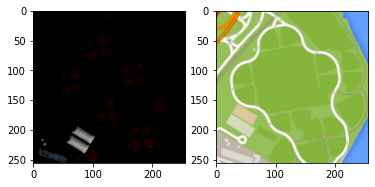

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor()
])
train_dataset = MapDataset('./maps/train/', train_transform, True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_x, train_y = next(iter(train_dataloader))

In [ ]:
gen = Gen(3).to(DEVICE)
disc = Disc(3).to(DEVICE)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE_DISC, betas=(0.5, 0.999))

gan_criterion = nn.MSELoss()
l1 = nn.L1Loss()
model_checkpoint = {
    "gen":None,
    "disc":None
}

In [ ]:
def sample_images(x, y, mode):
    fake_gen = gen(x)
    x_grid = torchvision.utils.make_grid(x, nrow=1, normalize=True)
    fake_grid = torchvision.utils.make_grid(fake_gen, nrow=1, normalize=True)
    y_grid = torchvision.utils.make_grid(y, nrow=1, normalize=True)
    res_img = torch.cat((x_grid, y_grid, fake_grid), dim=2)
    if mode == "test":
        torchvision.utils.save_image(res_img, "./output_img_testset/epoch_{epoch}_batch_{batch_idx}.png", normalize=False)
    if mode == "train":
        torchvision.utils.save_image(res_img, "./output_img_trainset/epoch_{epoch}_batch_{batch_idx}.png", normalize=False)
    print("saving samples... done!")

def save_checkpoint(dict, path="model.pth.tar"):
    """
    save the model and optim through a dictionary
     {"model": model.state_dict(), "optim": optim.state_dict()} (*)


    params:
        data: a dict of the structure (*) storing the model and optim

    return:
        None
    """
    now = time.strftime("%D_%H:%M")
    print(f"saving checkpoint at {now}, path is '{path}'")
    torch.save(dict, path)
    print("saving model... done!")


In [ ]:
for epoch in range(NUM_EPOCH):
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        gen.train()
        disc.train()

        opt_disc.zero_grad()
        fake_gen = gen(x)
        fake_disc = disc(torch.cat((x, fake_gen), dim=1))
        fake_disc_loss = gan_criterion(fake_disc, torch.zeros_like(fake_disc).to(DEVICE))
        real_disc = disc(torch.cat((x, y), dim=1))
        real_disc_loss = gan_criterion(real_disc, torch.ones_like(real_disc).to(DEVICE))
        disc_loss = fake_disc_loss + real_disc_loss
        disc_loss.backward()
        opt_disc.step()

        opt_gen.zero_grad()
        gen_gan_loss = gan_criterion(fake_disc, torch.ones_like(fake_disc).to(DEVICE))
        gen_l1_loss = l1(fake_gen, y)
        gen_loss = gen_gan_loss + gen_l1_loss
        gen_loss.backward()
        opt_gen.step()



        if batch_idx % 5 == 0:
          gen.eval()
          disc.eval()
          # GAN sample real and gen_result
          
          with torch.no_grad():
             sample_images(train_x, train_y)
             sample_images(test_x, test_y)
    # saving models
    model_checkpoint['gen']=gen.state_dict()
    model_checkpoint['disc']=disc.state_dict()
    save_checkpoint(model_checkpoint)

